In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import pertpy 

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
%%R

library("variancePartition")
library("edgeR")
library("BiocParallel")

Loading required package: ggplot2
Loading required package: limma
Loading required package: BiocParallel

Attaching package: ‘variancePartition’

The following object is masked from ‘package:limma’:

    topTable



# Identify outliers

In [3]:
adata_pb = sc.read('./pb_adata_DAO_combined.h5ad')
adata_pb

AnnData object with n_obs × n_vars = 561 × 27766
    obs: 'sample', 'sample_lesion', 'diagnosis', 'sample_source', 'cell_type', 'sample_rep', 'replicate_cat', 'stim', 'sex', 'seq_pool', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'batch', 'lib_size', 'log_lib_size'
    uns: 'age_cat_colors', 'cell_type_colors', 'diagnosis_colors', 'log1p', 'pca', 'pmi_cat2_colors', 'pmi_cat_colors', 'sample_source_colors', 'seq_pool_colors', 'sex_colors', 'stim_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [4]:
adata_pb.obs['cell_stim'] = adata_pb.obs['cell_type'].astype(str) + '_' + adata_pb.obs['stim'].astype(str)

In [5]:
# Extract the log_lib_size column
log_lib_size = adata_pb.obs['log_lib_size']

# Compute the median
median = np.median(log_lib_size)

# Compute the MAD (Median Absolute Deviation)
mad = np.median(np.abs(log_lib_size - median))

# Define the upper and lower thresholds
upper_threshold = median + 3 * mad
lower_threshold = median - 3 * mad

# Find outliers
outliers = adata_pb.obs[(log_lib_size < lower_threshold)]

# Print the results
print(f"Median: {median}, MAD: {mad}")
print(f"Lower threshold: {lower_threshold}")
print(f"Outliers:\n{outliers}")

Median: 13.570506037420834, MAD: 1.1301164955338834
Lower threshold: 10.180156550819184
Outliers:
                                            sample        sample_lesion  \
donor_Ind127-Sample2_0-1-0-0-0-0-0  Ind127-Sample2   Ind127-Sample2_CAL   
donor_Ind130-Sample4_0-1-0-0-0-0-0  Ind130-Sample4  Ind130-Sample4_NAWM   
donor_Ind122-Sample1_0-1-0-0        Ind122-Sample1    Ind122-Sample1_AL   
donor_Ind127-Sample2_0-1-0-0        Ind127-Sample2   Ind127-Sample2_CAL   
donor_Ind147-Sample1_0-1-0-0        Ind147-Sample1    Ind147-Sample1_RL   
donor_Ind102-Sample1_0-1-0          Ind102-Sample1    Ind102-Sample1_AL   
donor_Ind114-Sample1_0-1-0          Ind114-Sample1    Ind114-Sample1_AL   
donor_Ind127-Sample1_0-1-0          Ind127-Sample1    Ind127-Sample1_AL   
donor_Ind137-Sample1_0-1-0          Ind137-Sample1   Ind137-Sample1_CAL   
donor_Ind120-Sample1_0-1            Ind120-Sample1   Ind120-Sample1_CAL   
donor_Ind147-Sample1_0-1            Ind147-Sample1    Ind147-Sample1_RL   

 

In [6]:
# Compute the max and min log_lib_size
max_log_lib_size = log_lib_size.max()
min_log_lib_size = log_lib_size.min()

print(f"Maximum log_lib_size: {max_log_lib_size}")
print(f"Minimum log_lib_size: {min_log_lib_size}")

Maximum log_lib_size: 17.05357717593746
Minimum log_lib_size: 9.473857817428666


In [7]:
print(f"All samples: {adata_pb.shape[0]}")

All samples: 561


In [8]:
# Extract the data as a pandas DataFrame
df = adata_pb.obs[['cell_type', 'stim']]

# Create a summary table
summary_table = df.groupby(['cell_type', 'stim']).size().unstack(fill_value=0)
summary_table

stim,AL,CAL,CIL,NAWM,RL,WM
cell_type,,,,,,
COPs,1,0,2,1,1,0
DAO,19,15,12,16,10,8
MOL_A,19,16,12,17,11,13
MOL_B,20,16,13,17,11,13
MOL_C,21,16,13,17,11,13
MOL_D,18,14,10,14,11,10
MOL_E,9,7,4,9,6,5
OPCs,21,17,12,17,10,13


In [9]:
# Define the list of samples to remove
samples_to_remove = [
    'donor_Ind127-Sample2_0-1-0-0-0-0-0',
    'donor_Ind130-Sample4_0-1-0-0-0-0-0', 
    'donor_Ind122-Sample1_0-1-0-0',        
    'donor_Ind127-Sample2_0-1-0-0',           
    'donor_Ind147-Sample1_0-1-0-0',            
    'donor_Ind102-Sample1_0-1-0',              
    'donor_Ind114-Sample1_0-1-0',              
    'donor_Ind127-Sample1_0-1-0',              
    'donor_Ind137-Sample1_0-1-0',             
    'donor_Ind120-Sample1_0-1',                 
    'donor_Ind147-Sample1_0-1'                  
]

# Filter out the samples to remove
adata_pb = adata_pb[~adata_pb.obs.index.isin(samples_to_remove)].copy()

# Confirm removal
print(f"Remaining samples: {adata_pb.shape[0]}")

Remaining samples: 550


In [10]:
# Extract the data as a pandas DataFrame
df = adata_pb.obs[['cell_type', 'stim']]

# Create a summary table
summary_table = df.groupby(['cell_type', 'stim']).size().unstack(fill_value=0)
summary_table

stim,AL,CAL,CIL,NAWM,RL,WM
cell_type,,,,,,
COPs,1,0,2,1,1,0
DAO,19,14,12,16,9,8
MOL_A,19,15,12,16,11,13
MOL_B,20,16,13,17,11,13
MOL_C,21,16,13,17,11,13
MOL_D,17,13,10,14,10,10
MOL_E,6,6,4,9,6,5
OPCs,21,17,12,17,10,13


# Subset to relevant comparison 

In [11]:
# Extract the data as a pandas DataFrame
df = adata_pb.obs[['cell_type', 'stim']]

# Create a summary table
summary_table = df.groupby(['cell_type', 'stim']).size().unstack(fill_value=0)
summary_table

stim,AL,CAL,CIL,NAWM,RL,WM
cell_type,,,,,,
COPs,1,0,2,1,1,0
DAO,19,14,12,16,9,8
MOL_A,19,15,12,16,11,13
MOL_B,20,16,13,17,11,13
MOL_C,21,16,13,17,11,13
MOL_D,17,13,10,14,10,10
MOL_E,6,6,4,9,6,5
OPCs,21,17,12,17,10,13


In [12]:
adata_sub= adata_pb[np.in1d(adata_pb.obs['cell_type'], 
                           ['DAO', 'MOL_C'])].copy()

print("Dimensions of adata_sub:", adata_sub.shape)

Dimensions of adata_sub: (169, 27766)


In [13]:
adata_sub.obs[:5]

,sample,sample_lesion,diagnosis,sample_source,cell_type,sample_rep,replicate_cat,stim,sex,seq_pool,age_scale,age_cat,pmi_cat,pmi_cat2,batch,lib_size,log_lib_size,cell_stim
donor_Ind86-Sample2_0-1-0-0-0,Ind86-Sample2,Ind86-Sample2_WM,CTR,Edinburgh BB,MOL_C,WM_2,2,WM,M,Pool 2,0.782451,over_70,over_12H,over_12H,0,228293,12.338385,MOL_C_WM
donor_Ind98-Sample2_0-1-0-0-0,Ind98-Sample2,Ind98-Sample2_WM,CTR,Edinburgh BB,MOL_C,WM_1,1,WM,M,Pool 6,-1.759706,under_50,over_12H,over_12H,0,1320055,14.093184,MOL_C_WM
donor_Ind101-Sample1_0-1-0-0-0,Ind101-Sample1,Ind101-Sample1_CIL,SPMS,UK MS TB,MOL_C,CIL_1,1,CIL,F,Pool 5,0.645037,inbetween,over_12H,over_12H,0,242916,12.400471,MOL_C_CIL
donor_Ind101-Sample2_0-1-0-0-0,Ind101-Sample2,Ind101-Sample2_CIL,SPMS,UK MS TB,MOL_C,CIL_2,2,CIL,F,Pool 3,0.645037,inbetween,over_12H,over_12H,0,216898,12.287182,MOL_C_CIL
donor_Ind101-Sample3_0-1-0-0-0,Ind101-Sample3,Ind101-Sample3_RL,SPMS,UK MS TB,MOL_C,RL_1,1,RL,F,Pool 1,0.645037,inbetween,over_12H,over_12H,0,1664982,14.325325,MOL_C_RL


In [14]:
# Unique values in the 'condition' column
unique_conditions = adata_sub.obs['stim'].unique()
for condition in unique_conditions:
    print(condition)

WM
CIL
RL
NAWM
AL
CAL


In [15]:
adata_sub= adata_sub[np.in1d(adata_sub.obs['stim'], 
                           ['WM',
                              'RL'
                           ])].copy()

print("Dimensions of adata_sub:", adata_sub.shape)

Dimensions of adata_sub: (41, 27766)


In [16]:
# Check if the 'sample_rep' column exists
if 'sample_lesion' in adata_sub.obs.columns:
    # Set the 'sample_rep' column as the index
    adata_sub.obs.set_index('sample_lesion', inplace=True)
else:
    print("The column 'sample' does not exist in adata_sub.obs.")

adata_sub.obs.index.name = None

In [17]:
# Add the index back as a column called 'sample_lesion'
adata_sub.obs['sample_lesion'] = adata_sub.obs.index

In [18]:
adata_sub.obs['indiv_id'] = adata_sub.obs['sample'].str.split('-').str[0]
adata_sub.obs[:5]

,sample,diagnosis,sample_source,cell_type,sample_rep,replicate_cat,stim,sex,seq_pool,age_scale,age_cat,pmi_cat,pmi_cat2,batch,lib_size,log_lib_size,cell_stim,sample_lesion,indiv_id
Ind86-Sample2_WM,Ind86-Sample2,CTR,Edinburgh BB,MOL_C,WM_2,2,WM,M,Pool 2,0.782451,over_70,over_12H,over_12H,0,228293,12.338385,MOL_C_WM,Ind86-Sample2_WM,Ind86
Ind98-Sample2_WM,Ind98-Sample2,CTR,Edinburgh BB,MOL_C,WM_1,1,WM,M,Pool 6,-1.759706,under_50,over_12H,over_12H,0,1320055,14.093184,MOL_C_WM,Ind98-Sample2_WM,Ind98
Ind101-Sample3_RL,Ind101-Sample3,SPMS,UK MS TB,MOL_C,RL_1,1,RL,F,Pool 1,0.645037,inbetween,over_12H,over_12H,0,1664982,14.325325,MOL_C_RL,Ind101-Sample3_RL,Ind101
Ind104-Sample1_RL,Ind104-Sample1,SPMS,UK MS TB,MOL_C,RL_2,2,RL,F,Pool 5,0.645037,inbetween,over_12H,over_12H,0,768265,13.551890,MOL_C_RL,Ind104-Sample1_RL,Ind104
Ind107-Sample1_WM,Ind107-Sample1,CTR,Edinburgh BB,MOL_C,WM_3,3,WM,M,Pool 3,-0.935223,under_50,over_12H,over_12H,0,891756,13.700948,MOL_C_WM,Ind107-Sample1_WM,Ind107


In [19]:
# Extract the data as a pandas DataFrame
df = adata_sub.obs[['cell_stim', 'stim']]

# Create a summary table
summary_table = df.groupby(['cell_stim', 'stim']).size().unstack(fill_value=0)
summary_table

stim,RL,WM
cell_stim,,
DAO_RL,9,0
DAO_WM,0,8
MOL_C_RL,11,0
MOL_C_WM,0,13


In [20]:
adata_sub= adata_sub[np.in1d(adata_sub.obs['cell_stim'], 
                           ['MOL_C_WM',
                              'DAO_RL'
                           ])].copy()

print("Dimensions of adata_sub:", adata_sub.shape)

Dimensions of adata_sub: (22, 27766)


In [21]:
adata_sub

AnnData object with n_obs × n_vars = 22 × 27766
    obs: 'sample', 'diagnosis', 'sample_source', 'cell_type', 'sample_rep', 'replicate_cat', 'stim', 'sex', 'seq_pool', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'batch', 'lib_size', 'log_lib_size', 'cell_stim', 'sample_lesion', 'indiv_id'
    uns: 'age_cat_colors', 'cell_type_colors', 'diagnosis_colors', 'log1p', 'pca', 'pmi_cat2_colors', 'pmi_cat_colors', 'sample_source_colors', 'seq_pool_colors', 'sex_colors', 'stim_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

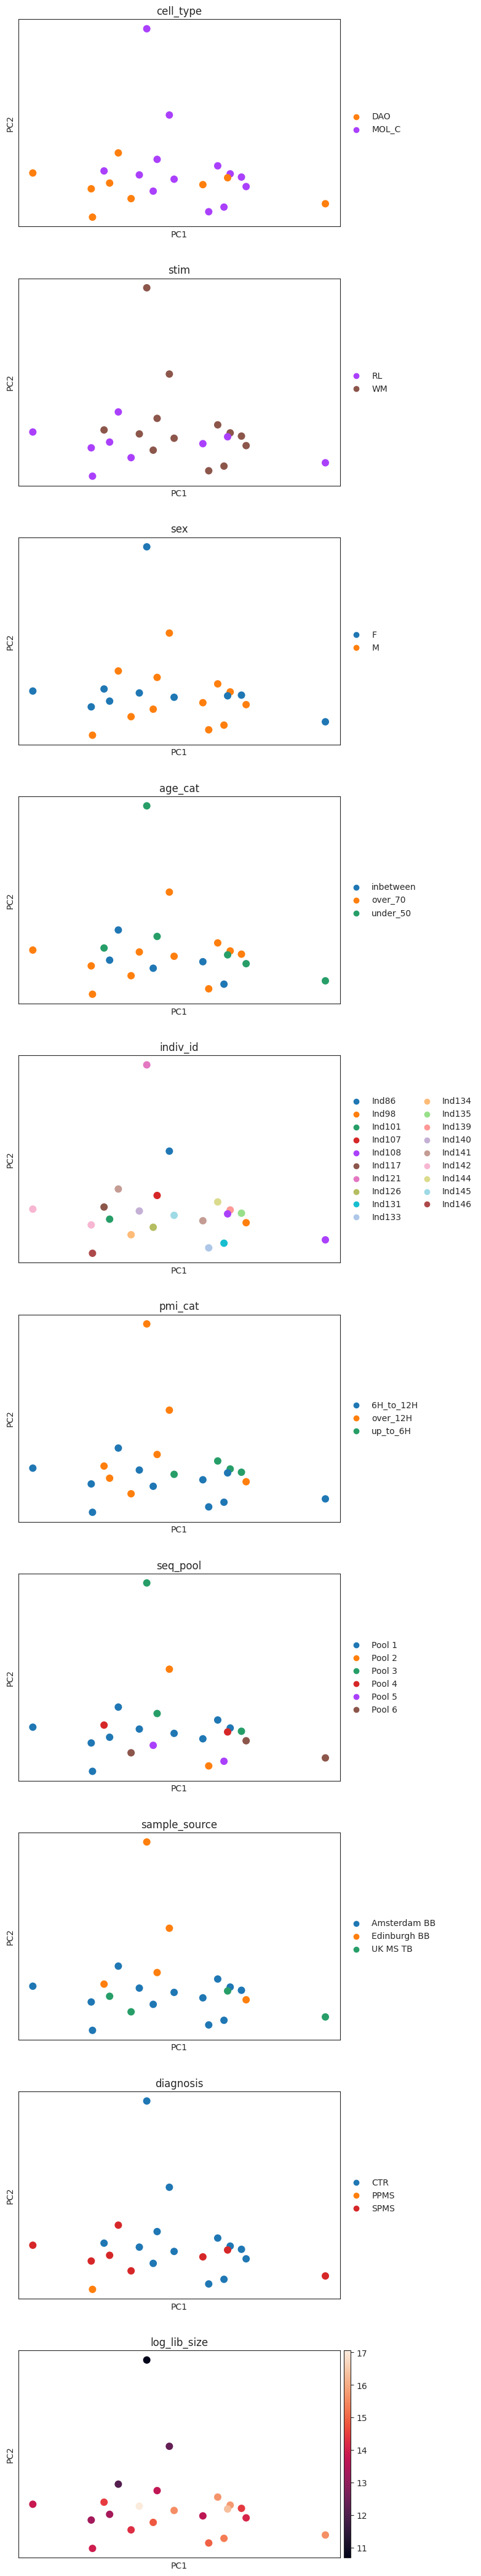

In [22]:
sc.pl.pca(adata_sub, color=["cell_type", "stim", "sex", "age_cat", "indiv_id",
                            "pmi_cat", "seq_pool", "sample_source", "diagnosis", "log_lib_size"], 
          ncols=1, size=300)

# Rename the MOL clusters for NEW letter based nomenclature

In [23]:
# Replace space with underscore in the 'seq_pool' column
adata_sub.obs['seq_pool'] = adata_sub.obs['seq_pool'].str.replace(' ', '_')
adata_sub.obs[:5]

,sample,diagnosis,sample_source,cell_type,sample_rep,replicate_cat,stim,sex,seq_pool,age_scale,age_cat,pmi_cat,pmi_cat2,batch,lib_size,log_lib_size,cell_stim,sample_lesion,indiv_id
Ind86-Sample2_WM,Ind86-Sample2,CTR,Edinburgh BB,MOL_C,WM_2,2,WM,M,Pool_2,0.782451,over_70,over_12H,over_12H,0,228293,12.338385,MOL_C_WM,Ind86-Sample2_WM,Ind86
Ind98-Sample2_WM,Ind98-Sample2,CTR,Edinburgh BB,MOL_C,WM_1,1,WM,M,Pool_6,-1.759706,under_50,over_12H,over_12H,0,1320055,14.093184,MOL_C_WM,Ind98-Sample2_WM,Ind98
Ind107-Sample1_WM,Ind107-Sample1,CTR,Edinburgh BB,MOL_C,WM_3,3,WM,M,Pool_3,-0.935223,under_50,over_12H,over_12H,0,891756,13.700948,MOL_C_WM,Ind107-Sample1_WM,Ind107
Ind117-Sample1_WM,Ind117-Sample1,CTR,Edinburgh BB,MOL_C,WM_4,4,WM,F,Pool_4,-0.935223,under_50,over_12H,over_12H,0,1868798,14.440806,MOL_C_WM,Ind117-Sample1_WM,Ind117
Ind121-Sample1_WM,Ind121-Sample1,CTR,Edinburgh BB,MOL_C,WM_5,5,WM,F,Pool_3,-0.729102,under_50,over_12H,over_12H,0,43506,10.680654,MOL_C_WM,Ind121-Sample1_WM,Ind121


In [24]:
#Check the counts data
print(adata_sub.X[:5, :5])

[[ 1  0  0  0 15]
 [11  1  0  0 37]
 [ 7  0  0  0 25]
 [13  0  0  0 55]
 [ 1  0  0  0  0]]


# Start R code: QC of log transformation

In [25]:
for col in adata_sub.obs.columns:
    if pd.api.types.is_categorical_dtype(adata_sub.obs[col]):
        adata_sub.obs[col] = adata_sub.obs[col].astype(str)

In [26]:
%%R -i adata_sub

# Concatenate label and cell type for group factor
group <- colData(adata_sub)$stim #ctrl or stim
replicate <- colData(adata_sub)$replicate_cat #replicate number
batch <- colData(adata_sub)$sample_lesion #this is each indiv sample

# Concatenate label and cell type for group factor
sex <- colData(adata_sub)$sex #ctrl or stim
age_cat <- colData(adata_sub)$age_cat #replicate number
pmi_cat <- colData(adata_sub)$pmi_cat #this is each indiv sample
pmi_cat2 <- colData(adata_sub)$pmi_cat2 #replicate number
seq_pool <- colData(adata_sub)$seq_pool #this is each indiv sample

treatments <- data.frame("Group"=group, "Reps"=replicate, "Batch"=batch,
                        "Sex"=sex, "Age_cat"=age_cat, "Pmi_cat"=pmi_cat, "Pmi_cat2"=pmi_cat2,
                        "Seq_pool"=seq_pool)
head(treatments)

                  Group Reps             Batch Sex   Age_cat   Pmi_cat
Ind86-Sample2_WM     WM    2  Ind86-Sample2_WM   M   over_70  over_12H
Ind98-Sample2_WM     WM    1  Ind98-Sample2_WM   M  under_50  over_12H
Ind107-Sample1_WM    WM    3 Ind107-Sample1_WM   M  under_50  over_12H
Ind117-Sample1_WM    WM    4 Ind117-Sample1_WM   F  under_50  over_12H
Ind121-Sample1_WM    WM    5 Ind121-Sample1_WM   F  under_50  over_12H
Ind126-Sample1_WM    WM    6 Ind126-Sample1_WM   M inbetween 6H_to_12H
                   Pmi_cat2 Seq_pool
Ind86-Sample2_WM   over_12H   Pool_2
Ind98-Sample2_WM   over_12H   Pool_6
Ind107-Sample1_WM  over_12H   Pool_3
Ind117-Sample1_WM  over_12H   Pool_4
Ind121-Sample1_WM  over_12H   Pool_3
Ind126-Sample1_WM up_to_12H   Pool_5


In [27]:
%%R -i adata_sub

# Create the treatments dataframe with samples as a column, not as row names
treatments <- data.frame(
  #Sample = colData(adata_sub)$sample,      # Sample column
  Group = colData(adata_sub)$stim,        # Group (e.g., ctrl or stim)
  Donor = colData(adata_sub)$indiv_id,    # Donor information
  Sex = colData(adata_sub)$sex,           # Sex information
  Age_cat = colData(adata_sub)$age_cat,   # Age category
  Pmi_cat = colData(adata_sub)$pmi_cat   # Post-mortem interval category
)

# Check the updated dataframe to confirm
head(treatments)

                  Group  Donor Sex   Age_cat   Pmi_cat
Ind86-Sample2_WM     WM  Ind86   M   over_70  over_12H
Ind98-Sample2_WM     WM  Ind98   M  under_50  over_12H
Ind107-Sample1_WM    WM Ind107   M  under_50  over_12H
Ind117-Sample1_WM    WM Ind117   F  under_50  over_12H
Ind121-Sample1_WM    WM Ind121   F  under_50  over_12H
Ind126-Sample1_WM    WM Ind126   M inbetween 6H_to_12H


In [28]:
%%R

#Create a DGElist object using the anndata counts in 'X'
x <- DGEList(assay(adata_sub, "X"), group=colData(adata_sub)$stim)

samplenames <- colnames(x$counts)

print("Dimensions before subsetting:")
print(dim(x))

# Check counts per group before filtering
print(table(x$samples$group))

[1] "Dimensions before subsetting:"
[1] 27766    22

RL WM 
 9 13 


In [29]:
%%R

# Adjust for batch-- ie publication in the model matrix
design_full <- model.matrix(~0 + Group + Sex + Age_cat + Pmi_cat, data=treatments)
rownames(design_full) <- colnames(x)
colnames(design_full)

[1] "GroupRL"         "GroupWM"         "SexM"            "Age_catover_70" 
[5] "Age_catunder_50" "Pmi_catover_12H" "Pmi_catup_to_6H"


In [30]:
%%R

# More strict removal of genes, tried group, pub and batch
keep.expr <- filterByExpr(x, design_full)
x2 <- x[keep.expr,, keep.lib.sizes=FALSE]
dim(x2)

[1] 12819    22


In [31]:
%%R

# More strict removal of genes, tried group, pub and batch
keep.exprs <- filterByExpr(x, group=batch)
b <- x[keep.exprs,, keep.lib.sizes=FALSE]
dim(b)

[1] 13994    22


In [32]:
%%R
## Calc norm factors before to normalize library sizes, then cpm divides counts by lib sizes
#X is before trimming, Y is after trimming, X2 is also trimmed but differently
x2 <- calcNormFactors(x2, method = "TMM")
x2$samples$norm.factors

 [1] 1.0217710 1.0115399 0.9674800 0.9703582 1.3146012 0.9894996 0.9886905
 [8] 1.0181281 0.8181991 0.9233182 0.9646083 0.8604018 0.9254931 1.0443229
[15] 1.0301700 0.9249830 1.0827512 1.0364111 1.0676968 0.9835105 1.0281906
[22] 1.1249732


In [33]:
%%R
cd <- x2$samples$group
print(cd)

 [1] WM WM WM WM WM WM WM WM WM WM WM WM WM RL RL RL RL RL RL RL RL RL
Levels: RL WM


# Check effect of batch correction?

In [ ]:
%%R
# Assuming 'group' is stored in y$samples dataframe
group <- x2$samples$group

# Generate a numeric vector from group factors (if not already factor, convert it)
group_factor <- as.factor(group)
group_colors <- as.numeric(group_factor)  # This converts factors to unique integers

# Define a set of colors corresponding to the factors
# Example: If you have two groups, you could define two colors
colors <- c("blue", "red")  # Adjust the number and colors based on your actual groups

# Use these colors in your plotMDS
plotMDS(x2, col = colors[group_colors])

# Adding a legend for clarity
legend("topright", legend=levels(group_factor), fill=colors, title="Group")

In [ ]:
%%R
# Convert to CPM and log2 transformation. 
logCPM <- edgeR::cpm(x2, log=TRUE, prior.count=3)
heatmap(logCPM)

In [ ]:
%%R
#Batch is set to the publication of origin to remove effects between sample origins
logCPM_no_batch <- removeBatchEffect(logCPM, batch=pmi_cat) 
heatmap(logCPM_no_batch)

In [ ]:
%%R

#Batch is set to the publication of origin to remove effects between sample origins
logCPM_no_batch_sex <- removeBatchEffect(logCPM, batch=sex) 
heatmap(logCPM_no_batch_sex)

In [ ]:
%%R

#Batch is set to the publication of origin to remove effects between sample origins
logCPM_no_batch_age <- removeBatchEffect(logCPM, batch=age_cat) 
heatmap(logCPM_no_batch_age)

In [ ]:
%%R

#Batch is set to the publication of origin to remove effects between sample origins
logCPM_no_batch_pool <- removeBatchEffect(logCPM, batch=seq_pool) 
heatmap(logCPM_no_batch_pool)

In [ ]:
%%R

# Convert categorical variables to factors
treatments$Batch <- as.factor(treatments$Batch)
treatments$Sex <- as.factor(treatments$Sex)
treatments$Age_cat <- as.factor(treatments$Age_cat)
treatments$Pmi_cat <- as.factor(treatments$Pmi_cat)
treatments$Seq_pool <- as.factor(treatments$Seq_pool)
treatments$Group <- as.factor(treatments$Group)

In [ ]:
%%R

# Correct for multiple batch effects
logCPM_no_batch <- removeBatchEffect(
  logCPM, 
  batch = treatments$Age_cat,   # Primary batch effect
  batch2 = treatments$Seq_pool,   # Secondary batch effect
  covariates = model.matrix(~ treatments$Pmi_cat + treatments$Sex)[, -1] # Other covariates
)

# Plot the corrected heatmap
heatmap(logCPM_no_batch)

In [ ]:
%%R

# Correct for multiple batch effects
logCPM_no_batch <- removeBatchEffect(
  logCPM, 
  batch = treatments$Seq_pool,   # Primary batch effect
  batch2 = treatments$Age_cat,   # Secondary batch effect
  covariates = model.matrix(~ treatments$Sex + treatments$Pmi_cat)[, -1] # Other covariates
)

# Plot the corrected heatmap
heatmap(logCPM_no_batch)

In [ ]:
%%R

donor <- colData(adata_sub)$indiv_id #this is each indiv sample

#Batch is set to the publication of origin to remove effects between sample origins
logCPM_no_batch <- removeBatchEffect(logCPM, batch=donor) 

In [ ]:
%%R

heatmap(logCPM_no_batch)

# Voom with quality weights- sex, age, pmi, seq_pool

In [34]:
%%R
head(treatments)

                  Group  Donor Sex   Age_cat   Pmi_cat
Ind86-Sample2_WM     WM  Ind86   M   over_70  over_12H
Ind98-Sample2_WM     WM  Ind98   M  under_50  over_12H
Ind107-Sample1_WM    WM Ind107   M  under_50  over_12H
Ind117-Sample1_WM    WM Ind117   F  under_50  over_12H
Ind121-Sample1_WM    WM Ind121   F  under_50  over_12H
Ind126-Sample1_WM    WM Ind126   M inbetween 6H_to_12H


In [35]:
%%R
donor <- colData(adata_sub)$indiv_id #this is each indiv sample
donor

 Ind86-Sample2_WM  Ind98-Sample2_WM Ind107-Sample1_WM Ind117-Sample1_WM 
          "Ind86"           "Ind98"          "Ind107"          "Ind117" 
Ind121-Sample1_WM Ind126-Sample1_WM Ind131-Sample1_WM Ind133-Sample1_WM 
         "Ind121"          "Ind126"          "Ind131"          "Ind133" 
Ind135-Sample1_WM Ind139-Sample1_WM Ind140-Sample1_WM Ind144-Sample1_WM 
         "Ind135"          "Ind139"          "Ind140"          "Ind144" 
Ind145-Sample1_WM Ind101-Sample3_RL Ind108-Sample3_RL Ind108-Sample4_RL 
         "Ind145"          "Ind101"          "Ind108"          "Ind108" 
Ind134-Sample3_RL Ind141-Sample1_RL Ind141-Sample2_RL Ind142-Sample1_RL 
         "Ind134"          "Ind141"          "Ind141"          "Ind142" 
Ind142-Sample2_RL Ind146-Sample1_RL 
         "Ind142"          "Ind146" 


In [36]:
%%R
head(design_full)

                  GroupRL GroupWM SexM Age_catover_70 Age_catunder_50
Ind86-Sample2_WM        0       1    1              1               0
Ind98-Sample2_WM        0       1    1              0               1
Ind107-Sample1_WM       0       1    1              0               1
Ind117-Sample1_WM       0       1    0              0               1
Ind121-Sample1_WM       0       1    0              0               1
Ind126-Sample1_WM       0       1    1              0               0
                  Pmi_catover_12H Pmi_catup_to_6H
Ind86-Sample2_WM                1               0
Ind98-Sample2_WM                1               0
Ind107-Sample1_WM               1               0
Ind117-Sample1_WM               1               0
Ind121-Sample1_WM               1               0
Ind126-Sample1_WM               0               0


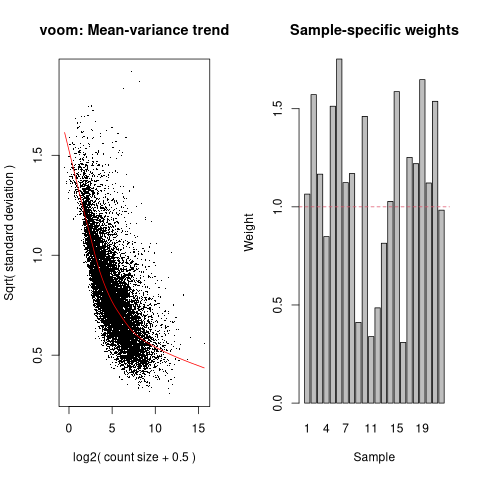

In [37]:
%%R

y_vqw_full <- voomWithQualityWeights(x2$counts, design_full, plot=TRUE)

In [38]:
%%R

corfit <- duplicateCorrelation(y_vqw_full, design_full, block=donor)
corfit$consensus.correlation

[1] 0.4114535


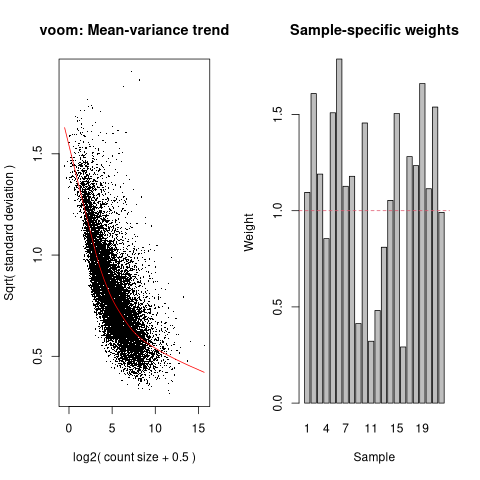

In [39]:
%%R

y2 <- voomWithQualityWeights(x2$counts, design_full, plot=TRUE, block=donor, correlation=corfit$consensus)

In [40]:
%%R

corfit2 <- duplicateCorrelation(y2, design_full, block=donor)
corfit2$consensus.correlation

[1] 0.412662


In [41]:
%%R

fit <- lmFit(y2, design_full, block=donor, correlation=corfit2$consensus)

In [42]:
%%R

contr <- makeContrasts(GroupRL - GroupWM, levels = colnames(coef(fit)))

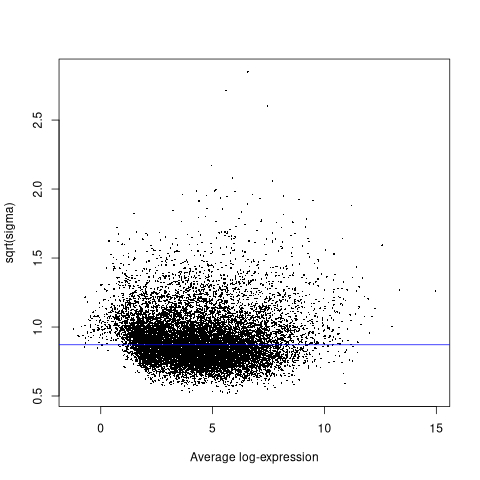

In [43]:
%%R

tmp <- contrasts.fit(fit, contr)
tmp2 <- eBayes(tmp)
tt_full <- topTable(tmp2, sort.by = "P", n = Inf)

plotSA(tmp2, xlab = "Average log-expression", ylab = "sqrt(sigma)", zero.weights = FALSE,
       pch = 16, cex = 0.3, col = c("black","red"))

In [44]:
%%R

# Retrieve the top results without sorting by p-value directly
tt <- topTable(tmp2, sort.by = "P", n = Inf)
head(tt, 10)

            logFC  AveExpr         t      P.Value    adj.P.Val        B
INPP5F   2.727772 5.572005  13.84195 6.171679e-12 7.911475e-08 17.22714
SHISA6   4.477838 3.000285  11.84075 1.106858e-10 4.899709e-07 13.88485
KCNAB1  -4.078930 6.635182 -11.65359 1.477538e-10 4.899709e-07 14.36206
MBOAT1   4.336051 2.461821  11.41350 2.151215e-10 4.899709e-07 13.05334
ST8SIA5  3.933221 4.517097  11.38309 2.256980e-10 4.899709e-07 13.65325
FCHSD2  -1.877978 8.738575 -11.37298 2.293335e-10 4.899709e-07 13.92418
OPALIN  -3.536266 7.688574 -10.86424 5.195445e-10 9.514345e-07 13.14275
EFR3B    2.333577 6.045235  10.44232 1.045537e-09 1.591166e-06 12.46501
PLPPR1  -2.119945 7.485930 -10.40296 1.117130e-09 1.591166e-06 12.38360
LGI4     2.359555 4.378743  10.28496 1.363985e-09 1.717739e-06 12.09640


In [45]:
%%R
length(which(tt$adj.P.Val < 0.05))

[1] 1739


In [46]:
%%R

# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- tt[tt$adj.P.Val < 0.05 & tt$logFC > 1, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 603
         logFC   AveExpr        t      P.Value    adj.P.Val        B
FOS   8.920771 1.8855648 5.112680 4.783793e-05 2.102348e-03 1.809227
EGR1  8.389111 1.4626581 7.370410 3.249537e-07 7.573784e-05 5.601869
GBP2  7.757696 0.7114883 5.594478 1.569254e-05 1.075613e-03 2.309895
GFAP  7.641508 1.0286919 6.790774 1.101921e-06 1.623624e-04 4.493666
ANXA2 7.297844 0.4356949 6.103852 4.958136e-06 4.780030e-04 3.135240
DCLK1 6.491777 1.9423491 5.822655 9.331934e-06 7.452493e-04 3.388748


In [47]:
%%R
genes_up_sorted

               logFC     AveExpr         t      P.Value    adj.P.Val
FOS         8.920771  1.88556481  5.112680 4.783793e-05 2.102348e-03
EGR1        8.389111  1.46265815  7.370410 3.249537e-07 7.573784e-05
GBP2        7.757696  0.71148834  5.594478 1.569254e-05 1.075613e-03
GFAP        7.641508  1.02869192  6.790774 1.101921e-06 1.623624e-04
ANXA2       7.297844  0.43569494  6.103852 4.958136e-06 4.780030e-04
DCLK1       6.491777  1.94234906  5.822655 9.331934e-06 7.452493e-04
NPTX2       6.298577  3.27198600  6.873052 9.240357e-07 1.427134e-04
JUNB        5.935403  1.92009138  5.282061 3.224987e-05 1.701280e-03
ARHGAP24    5.878213  3.50961278  7.405285 3.023686e-07 7.313325e-05
VIM         5.476351 -0.22686084  5.023432 5.894042e-05 2.413921e-03
CEBPD       5.280511  0.98506641  4.441113 2.329079e-04 5.725384e-03
VSIR        5.179069  1.70158709  8.191183 6.227740e-08 2.851193e-05
HLA-B       5.133526  2.35136630  8.683909 2.411337e-08 1.545546e-05
TUBB2A      5.005986  1.57552877  

SH2D3C      2.974563  0.26706265  3.572743 1.825429e-03 2.081546e-02
ABCA9       2.970212  3.42317463  4.844107 8.980528e-05 3.136823e-03
BACE2       2.967819  3.60210882  5.659436 1.352648e-05 9.581820e-04
MYRIP       2.955303  6.56086361 10.239369 1.473994e-09 1.717739e-06
MARCKS      2.947910  2.70802322  4.022557 6.295778e-04 1.083296e-02
AC011944.1  2.930556  1.35865705  5.116289 4.743646e-05 2.098666e-03
ARHGAP20    2.914656  1.42994867  3.229316 4.070582e-03 3.596803e-02
COL6A1      2.909624  1.66489854  3.368165 2.948156e-03 2.873530e-02
ADAMTS12    2.900273  0.17257662  3.893600 8.550582e-04 1.292570e-02
RASGRF1     2.874974  5.48649069  9.088345 1.132940e-08 9.076970e-06
FOSL1       2.864897 -0.44959715  3.033084 6.390753e-03 4.816171e-02
SETBP1      2.860814  4.42544543  7.276128 3.951432e-07 8.733347e-05
AC027117.2  2.859919  4.43588312  5.461094 2.131804e-05 1.256444e-03
ITGB4       2.846969  3.88874099  3.504880 2.141035e-03 2.294810e-02
HAP1        2.828467  0.18576123  

KCNIP3      2.023486  3.83227791  5.263456 3.367324e-05 1.718371e-03
BCL6        2.021608  6.05775598  3.280682 3.613721e-03 3.311243e-02
MFSD4A      2.015919  3.64627482  6.277584 3.370400e-06 3.785536e-04
KLF12       2.007631  2.98707850  3.329210 3.228252e-03 3.058608e-02
AZGP1       2.006722  4.39646354  4.124191 4.945044e-04 9.137128e-03
SEMA3A      1.997222  2.45051423  4.317723 3.121947e-04 6.906865e-03
CASZ1       1.994229  1.46824753  3.083468 5.695347e-03 4.451747e-02
USH1C       1.991375  2.09820504  3.573514 1.822121e-03 2.081546e-02
SEC24D      1.990460  2.63497754  3.126759 5.156781e-03 4.205131e-02
PDP1        1.985501  1.65513038  3.027344 6.474994e-03 4.862504e-02
CNBD1       1.985297  2.75821226  3.031859 6.408632e-03 4.821142e-02
ZC3HAV1     1.985041  1.64244454  5.169498 4.189970e-05 1.949493e-03
IL17RD      1.975284  1.02142757  3.830071 9.940361e-04 1.413368e-02
TRIM25      1.973608  1.47965602  3.552133 1.916098e-03 2.134079e-02
SP100       1.970588  1.67890241  

VAT1        1.569858  3.10013699  3.196854 4.387804e-03 3.782051e-02
VAV2        1.562018  3.10358815  4.270906 3.489279e-04 7.454845e-03
HMGCR       1.561545  5.03056576  5.808352 9.639365e-06 7.580798e-04
MYO5B       1.556474  4.49825238  3.717105 1.298684e-03 1.669792e-02
PLCB3       1.554762  1.50320258  4.073595 5.576852e-04 1.002660e-02
GPIHBP1     1.554434  4.90418591  5.429800 2.291269e-05 1.329040e-03
SYNM        1.551447  4.82698808  3.588178 1.760305e-03 2.034748e-02
SBK1        1.545553  1.57243250  3.575663 1.812929e-03 2.074995e-02
BCL2        1.544994  7.62356536  5.038857 5.684973e-05 2.366093e-03
MTHFD1L     1.543059  4.15234596  4.183041 4.299575e-04 8.505595e-03
AC097534.1  1.542038  1.23064859  3.017460 6.622563e-03 4.924283e-02
MAFK        1.535110  3.52241848  5.352358 2.740191e-05 1.526938e-03
RELL1       1.529892  3.07460216  3.274410 3.666713e-03 3.347834e-02
PRKCA       1.528602  8.05217405  3.960541 7.294706e-04 1.205036e-02
COL4A6      1.516206  1.14004802  

AP001347.1  1.243554  4.53349977  4.452463 2.267193e-04 5.643329e-03
RAB40C      1.243014  5.50890217  4.461505 2.219073e-04 5.566791e-03
SOAT1       1.241988  4.04335590  5.095289 4.982108e-05 2.164937e-03
MSI2        1.237251  7.51685547  6.039998 5.719166e-06 5.199574e-04
GPR146      1.236865  2.71213258  3.077381 5.775298e-03 4.502599e-02
GAS6        1.235880  4.57252716  3.055721 6.068722e-03 4.661171e-02
ACOT11      1.233280  3.32888306  4.564621 1.737832e-04 4.874674e-03
ASNS        1.232286  4.34745969  3.066377 5.922607e-03 4.582813e-02
ADAM19      1.226928  4.70644282  3.612178 1.663566e-03 1.963652e-02
TNIP2       1.226794  3.21579860  3.933466 7.778907e-04 1.234131e-02
GNG5        1.225612  2.92850779  4.428614 2.399200e-04 5.835928e-03
FDFT1       1.224633  7.56338874  5.141357 4.474107e-05 2.012406e-03
CARS        1.224629  6.04664727  3.443810 2.470521e-03 2.518868e-02
EPHA10      1.212909  2.67633833  3.164025 4.732987e-03 3.968094e-02
AC244453.3  1.211557  3.23520525  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [48]:
%%R

# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- tt[tt$adj.P.Val < 0.05 & tt$logFC < -1, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 254
             logFC  AveExpr          t      P.Value    adj.P.Val          B
ITM2A    -5.086929 1.592007  -3.381426 2.858336e-03 2.803444e-02 -1.5643870
KCNAB1   -4.078930 6.635182 -11.653588 1.477538e-10 4.899709e-07 14.3620608
TMEM179  -3.847072 2.264217  -7.243693 4.227592e-07 9.185339e-05  6.1954477
PCDH7    -3.668293 3.488270  -3.949209 7.493599e-04 1.216034e-02 -0.4396785
NRXN1    -3.654716 2.281597  -3.834163 9.844441e-04 1.407790e-02 -0.6934351
MTRNR2L8 -3.605135 4.679580  -4.718452 1.207771e-04 3.886697e-03  1.0516395


In [49]:
%%R

# Add row names as a new column
tt$gene <- rownames(tt)

# Optionally reorder or select columns
tt <- tt[, c("gene", names(tt)[1:6])]

# Write to CSV file
write.table(tt, file = "./files/DAO_WM_v_RL_vwqw_blocked.csv", row.names = FALSE, sep = ",", quote = FALSE)

# Dream analysis

In [50]:
%%R

options(ports=8888)

In [51]:
%%R

param <- SnowParam(4, "SOCK", progressbar = TRUE)

In [52]:
%%R
head(treatments)

                  Group  Donor Sex   Age_cat   Pmi_cat
Ind86-Sample2_WM     WM  Ind86   M   over_70  over_12H
Ind98-Sample2_WM     WM  Ind98   M  under_50  over_12H
Ind107-Sample1_WM    WM Ind107   M  under_50  over_12H
Ind117-Sample1_WM    WM Ind117   F  under_50  over_12H
Ind121-Sample1_WM    WM Ind121   F  under_50  over_12H
Ind126-Sample1_WM    WM Ind126   M inbetween 6H_to_12H


In [53]:
%%R

# Convert Group column to a factor
treatments$Group <- factor(treatments$Group)

# Check levels to confirm AL and WM exist
levels(treatments$Group)

[1] "RL" "WM"


In [54]:
%%R

form <- ~ Group + (1 | Donor)

In [56]:
%%R

vobjDream <- voomWithDreamWeights(x2, form, treatments)

In [57]:
%%R

fitmm <- dream(vobjDream, form, treatments)
fitmm <- eBayes(fitmm)

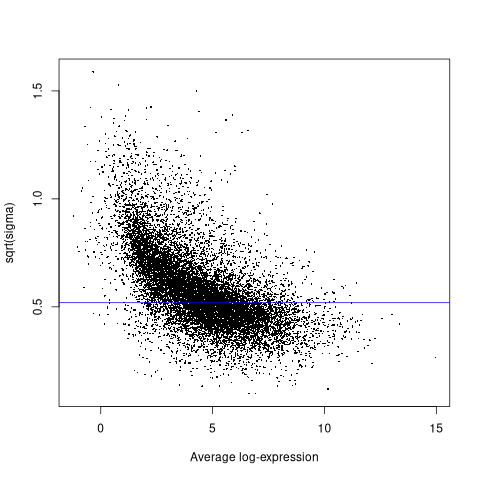

In [58]:
%%R

plotSA(fitmm, xlab = "Average log-expression", ylab = "sqrt(sigma)", zero.weights = FALSE,
       pch = 16, cex = 0.3, col = c("black","red"))

In [59]:
%%R

head(fitmm$design, 5)

                  (Intercept) GroupWM
Ind86-Sample2_WM            1       1
Ind98-Sample2_WM            1       1
Ind107-Sample1_WM           1       1
Ind117-Sample1_WM           1       1
Ind121-Sample1_WM           1       1


In [60]:
%%R

tt_dream <- topTable(fitmm, sort.by = "P", n = Inf)

Removing intercept from test coefficients


In [61]:
%%R
length(which(tt_dream$adj.P.Val < 0.05))

[1] 915


In [91]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- tt_dream[tt_dream$adj.P.Val < 0.05 & tt_dream$logFC > 0.585, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 397
           gene    logFC  AveExpr        t      P.Value    adj.P.Val          B
ATP8A2   ATP8A2 5.162330 5.141551 5.162748 3.231897e-05 0.0034814868  2.4466579
GRM7       GRM7 5.073142 3.199721 5.407198 1.778022e-05 0.0024152693  2.8896429
DPP10     DPP10 4.922820 2.622869 3.483125 2.045030e-03 0.0368191520 -2.3038120
ARPP21   ARPP21 4.786105 2.906167 4.273950 2.909801e-04 0.0131804735 -0.2130589
ST3GAL6 ST3GAL6 4.276368 4.532240 6.670580 1.196769e-06 0.0005479064  4.7247015
FAM155A FAM155A 3.991249 1.234964 3.393851 2.602587e-03 0.0420219643 -1.7107085
           z.std  gene.1
ATP8A2  4.156479  ATP8A2
GRM7    4.291085    GRM7
DPP10   3.083614   DPP10
ARPP21  3.623200  ARPP21
ST3GAL6 4.856172 ST3GAL6
FAM155A 3.011152 FAM155A


In [ ]:
%%R
head(genes_up_sorted, 20)

In [92]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- tt_dream[tt_dream$adj.P.Val < 0.05 & tt_dream$logFC < -0.585, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 373
             gene     logFC   AveExpr         t      P.Value   adj.P.Val
EGR1         EGR1 -5.352240 1.4626585 -4.440076 3.069417e-04 0.013428962
GBP2         GBP2 -4.913090 0.7114887 -4.292273 4.135597e-04 0.015909078
HLA-B       HLA-B -4.579207 2.3513667 -7.340629 5.336009e-06 0.001554598
ARHGAP24 ARHGAP24 -4.503753 3.5096132 -5.803042 4.199181e-05 0.003991732
GPRC5A     GPRC5A -4.378517 0.8904539 -4.927913 8.138514e-05 0.005894215
ANXA2       ANXA2 -4.370058 0.4356953 -4.713307 1.461686e-04 0.008516978
                  B     z.std   gene.1
EGR1     -0.8801885 -3.609370     EGR1
GBP2     -2.3164972 -3.531276     GBP2
HLA-B     1.8666818 -4.551124    HLA-B
ARHGAP24  1.6597034 -4.096238 ARHGAP24
GPRC5A    0.4993955 -3.940284   GPRC5A
ANXA2    -2.5041936 -3.797490    ANXA2


In [ ]:
%%R

head(genes_down_sorted, 20)

In [64]:
%%R

# Add row names as a new column
tt_dream$gene <- rownames(tt_dream)

In [65]:
%%R
head(tt_dream)

               logFC  AveExpr         t      P.Value    adj.P.Val         B
FCHSD2      2.084488 8.738575 17.784389 7.903566e-15 1.013158e-10 21.739217
AC022182.1  2.343489 3.684697 11.832180 3.429527e-11 1.779344e-07 14.493931
KCNAB1      3.883984 6.635182 11.715882 4.164156e-11 1.779344e-07 14.120490
PLPPR1      2.146968 7.485931 11.462789 3.100570e-10 9.936551e-07  9.244501
AL589669.1  1.670073 4.309478  8.827445 8.441358e-09 2.164195e-05 10.111599
RGMB       -2.142740 2.910058 -8.479747 1.714989e-08 3.652640e-05  9.613876
               z.std       gene
FCHSD2      7.769116     FCHSD2
AC022182.1  6.626838 AC022182.1
KCNAB1      6.598116     KCNAB1
PLPPR1      6.293665     PLPPR1
AL589669.1  5.759400 AL589669.1
RGMB       -5.638539       RGMB


In [66]:
%%R

# Optionally reorder or select columns
tt_dream <- tt_dream[, c("gene", names(tt_dream)[1:8])]

# Write to CSV file
write.table(tt_dream, file = "./files/DAO_WM_v_RL_dream.csv", row.names = FALSE, sep = ",", quote = FALSE)

## Next try with additional variables

In [ ]:
%%R
colnames(treatments)

In [ ]:
%%R

form <- ~ 0 + Group + Sex + Age_cat + Pmi_cat + (1 | Donor)

In [ ]:
%%R

L <- makeContrastsDream(form, treatments,
  contrasts = c(
    compare1 = "GroupRL - GroupWM"
  )
)

# Visualize contrast matrix
plotContrasts(L)

In [ ]:
%%R

vobjDream2 <- voomWithDreamWeights(x2, form, treatments, BPPARAM = param)

In [ ]:
%%R

# fit dream model with contrasts
fit_full <- dream(vobjDream2, form, treatments, L)
fit_full <- eBayes(fit_full)

# get names of available coefficients and contrasts for testing
colnames(fit_full)

In [ ]:
%%R

tt_dream_full <- topTable(fit_full, coef="compare1", sort.by = "P", n = Inf)

In [ ]:
%%R

head(tt_dream_full)

In [ ]:
%%R

length(which(tt_dream_full$adj.P.Val < 0.05))

In [ ]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- tt_dream[tt_dream$adj.P.Val < 0.05 & tt_dream$logFC > 0.7, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

In [ ]:
%%R

head(genes_up_sorted, 20)

In [ ]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- tt_dream[tt_dream$adj.P.Val < 0.05 & tt_dream$logFC < -0.7, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

In [ ]:
%%R

head(genes_down_sorted, 20)

## Variance partition plots

In [ ]:
%%R

form <- ~ (1 | Group) + (1 | Sex) + (1 | Donor)
vp <- fitExtractVarPartModel(y2, form, treatments)

plotVarPart(sortCols(vp))

In [ ]:
%%R

form <- ~ (1 | Group) + (1 | Sex) + (1 | Age_cat) + (1 | Pmi_cat) + (1 | Donor)
vp <- fitExtractVarPartModel(y2, form, treatments)

plotVarPart(sortCols(vp))

In [ ]:
%%R
dim(tmp2)

In [ ]:
%%R
dim(fitmm)

In [ ]:
%%R
all(rownames(tmp2) == rownames(fitmm))

In [ ]:
%%R
dim(vp)

In [ ]:
%%R
all(rownames(tmp2) == rownames(vp))

In [ ]:
%%R

# Compare p-values and make plot
p1 <- topTable(tmp2, coef = "GroupRL - GroupWM", number = Inf, sort.by = "none")$P.Value
p2 <- topTable(fitmm, number = Inf, sort.by = "none")$P.Value

plotCompareP(p1, p2, vp$Donor, corfit2$consensus)

# Box plots of highly differentially expressed genes

In [ ]:
%%R
library(reshape2)  # For transforming data from wide to long format
library(ggplot2)   # For plotting
library(edgeR)

In [ ]:
%%R
class(x2)

In [ ]:
%%R
#X2 is the norm lib sizes and trimmed
cpm <- edgeR::cpm(x2, log=FALSE, prior.counts=3)
lcpm <- edgeR::cpm(x2, log=TRUE, prior.count=3)

In [ ]:
%%R
class(cpm)

In [ ]:
%%R

# Step 1: Combine Expression and Treatment Data
# Convert the E matrix into a dataframe
expr_df <- as.data.frame(cpm)
expr_df$gene <- rownames(cpm)  # Add gene names as a column
head(expr_df)

In [ ]:
%%R
colnames(expr_df)

In [ ]:
%%R
# Drop the "gene" column
expr_df <- expr_df[, !colnames(expr_df) %in% "gene"]

In [ ]:
%%R

# Convert design matrix to a dataframe and add sample IDs as rownames
design_df <- as.data.frame(y2$design)
design_df$sample <- rownames(design_df)
head(design_df)

In [ ]:
%%R

# Step 1: Rename the columns of expr_df to match the design information
colnames(expr_df) <- paste0("Sample", seq_len(ncol(expr_df) - 1))  # Adjust for gene column
expr_df$gene <- rownames(expr_df)

# Update design_df to have corresponding sample IDs
design_df$sample <- paste0("Sample", seq_len(nrow(design_df)))

# Step 2: Melt the expression data into a long format
expr_long <- melt(expr_df, id.vars = "gene", variable.name = "sample", value.name = "expression")

# Step 3: Merge expression data with treatment information
expr_treatment <- merge(expr_long, design_df, by = "sample")

In [ ]:
%%R
head(expr_treatment)

In [ ]:
%%R
# Subset data for the specified gene
gene_data <- subset(expr_treatment, gene == "HLA-B")
gene_data$treatment <- ifelse(gene_data$GroupWM == 1, "WM", "AL")
head(gene_data)

In [ ]:
%%R
ggplot(gene_data, aes(x = treatment, y = expression, fill = treatment)) +
  geom_boxplot(alpha = 0.5, outlier.shape = NA) +  # Boxplots without outliers
  geom_jitter(width = 0.2, alpha = 0.7, size = 2, aes(color = treatment)) +  # Individual points
  scale_fill_manual(values = c("WM" = "blue", "AL" = "red")) +  # Custom colors for boxes
  scale_color_manual(values = c("WM" = "blue", "AL" = "red")) +  # Custom colors for points
  labs(
    title = "Expression of HLA-B in MOLs",
    x = "",
    y = "Counts per million"
  ) +
  theme_minimal() +
  theme(legend.position = "none")

In [ ]:
%%R
# Subset data for the specified gene
gene_data <- subset(expr_treatment, gene == "GBP2")
gene_data$treatment <- ifelse(gene_data$GroupWM == 1, "WM", "AL")
head(gene_data)

In [ ]:
%%R
ggplot(gene_data, aes(x = treatment, y = expression, fill = treatment)) +
  geom_boxplot(alpha = 0.5, outlier.shape = NA) +  # Boxplots without outliers
  geom_jitter(width = 0.2, alpha = 0.7, size = 2, aes(color = treatment)) +  # Individual points
  scale_fill_manual(values = c("WM" = "blue", "AL" = "red")) +  # Custom colors for boxes
  scale_color_manual(values = c("WM" = "blue", "AL" = "red")) +  # Custom colors for points
  labs(
    title = "Expression of HSPA6 in OPCs",
    x = "",
    y = "Counts per million"
  ) +
  theme_minimal() +
  theme(legend.position = "none")

# Try to plot some genes to see if you belive results

In [ ]:
import scanpy as sc
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm, colors
#from gprofiler import gprofiler

In [ ]:
from matplotlib import rcParams
from matplotlib import cm, colors

# Create a custom color map using 'PuRd' color map
colors2 = plt.cm.PuRd(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7, 0.8, 20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [ ]:
#Define a nice colour map for gene expression
colors2 = plt.cm.plasma(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap2 = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [ ]:
plt.rcParams['figure.figsize']=(5,5) #rescale figures
sc.settings.verbosity = 3
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=300,transparent=True, fontsize=12) #color_map=mymap2)
sc.settings.figdir = '/afs/crc.nd.edu/user/e/eaboelno/sysVI_analysis/Human_scVI_single/figures_OL/'
sc.logging.print_header()

In [ ]:
adata= sc.read_h5ad('/scratch365/eaboelno/BACKUP_h5ad_IMPORTANT/scVI_mdata_OL_NEW.h5ad')
adata

In [ ]:
sc.tl.dendrogram(adata, 'lesion_type')
sc.pl.dendrogram(adata, 'lesion_type')

In [ ]:
# Specify the gene name you want to include in the filename
gene_name = 'HLA-B'  # You can change this to any gene name you wish to use

# Loop through each unique value in 'lesion_status'
for lesion_type in set(adata.obs['lesion_type']):
    # Subset the data to only include the current lesion type
    adata_subset = adata[adata.obs['lesion_type'] == lesion_type]
    
    # Generate the UMAP plot for the current subset
    sc.pl.embedding(
        adata_subset, 
        basis='X_umap', 
        color=gene_name,  # Use the gene name
        layer='log1p_norm',
        color_map=mymap, 
        legend_fontweight='normal', 
        s=20, 
        frameon=False,
        vmax=4,
        title=f"Lesion Type: {lesion_type}",
        #save=f'_{gene_name}_lesion_status_{lesion_type}.png'  # Save with gene name and lesion type
    )
    
    # Show the plot
    plt.show()

In [ ]:
# Specify the gene name you want to include in the filename
gene_name = 'GBP2'  # You can change this to any gene name you wish to use

# Loop through each unique value in 'lesion_status'
for lesion_type in set(adata.obs['lesion_type']):
    # Subset the data to only include the current lesion type
    adata_subset = adata[adata.obs['lesion_type'] == lesion_type]
    
    # Generate the UMAP plot for the current subset
    sc.pl.embedding(
        adata_subset, 
        basis='X_umap', 
        color=gene_name,  # Use the gene name
        layer='log1p_norm',
        color_map=mymap, 
        legend_fontweight='normal', 
        s=20, 
        frameon=False,
        vmax=4,
        title=f"Lesion Type: {lesion_type}",
        #save=f'_{gene_name}_lesion_status_{lesion_type}.png'  # Save with gene name and lesion type
    )
    
    # Show the plot
    plt.show()

# Do results overlap with LR pairs?

In [67]:
import liana as li

In [68]:
lr_pairs = li.resource.select_resource('consensus')
lr_pairs.head()

,ligand,receptor
0,LGALS9,PTPRC
1,LGALS9,MET
2,LGALS9,CD44
3,LGALS9,LRP1
4,LGALS9,CD47


In [69]:
%R -o tt_dream

In [70]:
# Display the first few rows
tt_dream.head()

,gene,logFC,AveExpr,t,P.Value,adj.P.Val,B,z.std,gene.1
FCHSD2,FCHSD2,2.084488,8.738575,17.784389,7.903566e-15,1.013158e-10,21.739217,7.769116,FCHSD2
AC022182.1,AC022182.1,2.343489,3.684697,11.832180,3.429527e-11,1.779344e-07,14.493931,6.626838,AC022182.1
KCNAB1,KCNAB1,3.883984,6.635182,11.715882,4.164156e-11,1.779344e-07,14.120490,6.598116,KCNAB1
PLPPR1,PLPPR1,2.146968,7.485931,11.462789,3.100570e-10,9.936551e-07,9.244501,6.293665,PLPPR1
AL589669.1,AL589669.1,1.670073,4.309478,8.827445,8.441358e-09,2.164195e-05,10.111599,5.759400,AL589669.1


In [71]:
tt_dream.rename(columns={'adj.P.Val': 'Padj'}, inplace=True)
tt_dream.rename(columns={'P.Value': 'Pvalue'}, inplace=True)

In [72]:
# Move row names to a column called 'gene'
tt_dream['gene'] = tt_dream.index

# Reset the index so the gene names become part of the dataframe
tt_dream.reset_index(drop=True, inplace=True)

# Display the updated dataframe
tt_dream.head()

,gene,logFC,AveExpr,t,Pvalue,Padj,B,z.std,gene.1
0,FCHSD2,2.084488,8.738575,17.784389,7.903566e-15,1.013158e-10,21.739217,7.769116,FCHSD2
1,AC022182.1,2.343489,3.684697,11.832180,3.429527e-11,1.779344e-07,14.493931,6.626838,AC022182.1
2,KCNAB1,3.883984,6.635182,11.715882,4.164156e-11,1.779344e-07,14.120490,6.598116,KCNAB1
3,PLPPR1,2.146968,7.485931,11.462789,3.100570e-10,9.936551e-07,9.244501,6.293665,PLPPR1
4,AL589669.1,1.670073,4.309478,8.827445,8.441358e-09,2.164195e-05,10.111599,5.759400,AL589669.1


In [73]:
sigs = tt_dream[(tt_dream.Padj < 0.05) & (abs(tt_dream.logFC) >= 1)]
sigs.shape

(502, 9)

In [74]:
lr_pairs.shape

(4624, 2)

In [75]:
sigs.head()

,gene,logFC,AveExpr,t,Pvalue,Padj,B,z.std,gene.1
0,FCHSD2,2.084488,8.738575,17.784389,7.903566e-15,1.013158e-10,21.739217,7.769116,FCHSD2
1,AC022182.1,2.343489,3.684697,11.832180,3.429527e-11,1.779344e-07,14.493931,6.626838,AC022182.1
2,KCNAB1,3.883984,6.635182,11.715882,4.164156e-11,1.779344e-07,14.120490,6.598116,KCNAB1
3,PLPPR1,2.146968,7.485931,11.462789,3.100570e-10,9.936551e-07,9.244501,6.293665,PLPPR1
4,AL589669.1,1.670073,4.309478,8.827445,8.441358e-09,2.164195e-05,10.111599,5.759400,AL589669.1


In [76]:
ligands = lr_pairs['ligand'].unique()
receptors = lr_pairs['receptor'].unique()

# Combining both ligands and receptors and keeping only unique values
unique_genes = set(ligands).union(set(receptors))

# Checking for overlap with 'sigs' dataframe on the 'gene' column
overlap_genes = sigs[sigs['gene'].isin(unique_genes)]
overlap_genes

,gene,logFC,AveExpr,t,Pvalue,Padj,B,z.std,gene.1
5,RGMB,-2.142740,2.910058,-8.479747,1.714989e-08,0.000037,9.613876,-5.638539,RGMB
7,HLA-F,-3.527163,0.853943,-8.096172,3.818826e-08,0.000061,8.762609,-5.499032,HLA-F
18,LRP6,1.248583,7.084961,7.570539,4.889244e-07,0.000330,6.344266,5.030609,LRP6
19,LGI4,-2.020344,4.378744,-7.522385,5.360579e-07,0.000344,0.412424,-5.012936,LGI4
22,NGFR,-2.791753,3.062552,-7.458821,8.104265e-07,0.000452,-0.895362,-4.932840,NGFR
...,...,...,...,...,...,...,...,...,...
811,PTPRM,-2.337299,7.810954,-3.450397,2.814333e-03,0.044324,-3.438847,-2.987322,PTPRM
825,CD59,-1.700309,0.986505,-3.512847,2.895149e-03,0.044931,-1.774880,-2.978657,CD59
867,ETV5,-1.897185,4.525553,-3.404888,3.187393e-03,0.047053,-2.511318,-2.949063,ETV5
871,IFNA2,2.187552,0.862313,3.298939,3.221053e-03,0.047352,-2.188410,2.945815,IFNA2


In [77]:
# Checking the direction of logFC for the overlapping genes
overlap_genes_direction = overlap_genes[['gene', 'logFC']].copy()

# Determine the direction of logFC
overlap_genes_direction['logFC_direction'] = overlap_genes_direction['logFC'].apply(lambda x: 'positive' if x > 0 else 'negative')

# Displaying the results
overlap_genes_direction

,gene,logFC,logFC_direction
5,RGMB,-2.142740,negative
7,HLA-F,-3.527163,negative
18,LRP6,1.248583,positive
19,LGI4,-2.020344,negative
22,NGFR,-2.791753,negative
...,...,...,...
811,PTPRM,-2.337299,negative
825,CD59,-1.700309,negative
867,ETV5,-1.897185,negative
871,IFNA2,2.187552,positive


In [78]:
# Step 1: Convert ligands and receptors to a list
ligands = lr_pairs['ligand'].tolist()
receptors = lr_pairs['receptor'].tolist()

# Step 2: Filter DEGs from 'sigs'
degs = set(sigs['gene'])  # Create a set for faster lookup

# Step 3: Check which ligand-receptor pairs have both ligands and receptors as DEGs
matched_pairs = lr_pairs[(lr_pairs['ligand'].isin(degs)) & (lr_pairs['receptor'].isin(degs))]

# Step 4: Count the matched pairs
num_matched_pairs = matched_pairs.shape[0]

# Output the result
print(f'Total ligand-receptor pairs where both are differentially expressed: {num_matched_pairs}')

# Step 5: Optional - view the matched pairs with direction of change
matched_pairs_with_logFC = matched_pairs.merge(sigs[['gene', 'logFC']], left_on='ligand', right_on='gene', how='left')\
                                        .merge(sigs[['gene', 'logFC']], left_on='receptor', right_on='gene', how='left', suffixes=('_ligand', '_receptor'))

# Sorting the table by 'logFC_ligand' in descending order
sorted_table = matched_pairs_with_logFC.sort_values(by='logFC_ligand', ascending=False)

# Displaying the sorted table with the selected columns
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']]

Total ligand-receptor pairs where both are differentially expressed: 7


,ligand,receptor,logFC_ligand,logFC_receptor
0,CDH1,PTPRM,2.121921,-2.337299
1,LAMA2,CD44,2.025852,-3.090808
2,LTBP1,ITGB5,1.257049,-1.050179
5,FSTL5,IL6R,-2.232427,-2.799701
6,MFGE8,ITGB5,-2.235172,-1.050179
4,COL18A1,ITGB5,-2.469786,-1.050179
3,VIM,CD44,-3.610630,-3.090808


In [79]:
sigs_up = tt_dream[(tt_dream.Padj < 0.05) & (tt_dream.logFC <= -1)]
sigs_up.shape

(225, 9)

In [80]:
# Step 1: Convert ligands and receptors to a list
ligands = lr_pairs['ligand'].tolist()
receptors = lr_pairs['receptor'].tolist()

# Step 2: Filter DEGs from 'sigs'
degs = set(sigs_up['gene'])  # Create a set for faster lookup

# Step 3: Check which ligand-receptor pairs have both ligands and receptors as DEGs
matched_pairs = lr_pairs[(lr_pairs['ligand'].isin(degs)) & (lr_pairs['receptor'].isin(degs))]

# Step 4: Count the matched pairs
num_matched_pairs = matched_pairs.shape[0]

# Output the result
print(f'Total ligand-receptor pairs where both are differentially expressed: {num_matched_pairs}')

# Step 5: Optional - view the matched pairs with direction of change
matched_pairs_with_logFC = matched_pairs.merge(sigs[['gene', 'logFC']], left_on='ligand', right_on='gene', how='left')\
                                        .merge(sigs[['gene', 'logFC']], left_on='receptor', right_on='gene', how='left', suffixes=('_ligand', '_receptor'))

# Sorting the table by 'logFC_ligand' in descending order
sorted_table = matched_pairs_with_logFC.sort_values(by='logFC_ligand', ascending=True)

# Displaying the sorted table with the selected columns
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']]

Total ligand-receptor pairs where both are differentially expressed: 4


,ligand,receptor,logFC_ligand,logFC_receptor
0,VIM,CD44,-3.610630,-3.090808
1,COL18A1,ITGB5,-2.469786,-1.050179
3,MFGE8,ITGB5,-2.235172,-1.050179
2,FSTL5,IL6R,-2.232427,-2.799701


In [81]:
#sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']].to_csv('./files/LR_pairs_OPC_up_AL_CAL_updated.csv', sep='\t', index=False)

# Check overlap voom-wqw and dream

In [82]:
OPC_orig = pd.read_csv('./files/DAO_WM_v_RL_vwqw_blocked.csv', index_col=None)
OPC_orig.rename(columns={'adj.P.Val': 'Padj'}, inplace=True)
OPC_orig.rename(columns={'P.Value': 'Pvalue'}, inplace=True)
OPC_orig.shape

(12819, 7)

In [83]:
OPC_orig.head

<bound method NDFrame.head of           gene     logFC   AveExpr          t        Pvalue          Padj  \
0       INPP5F  2.727772  5.572005  13.841951  6.171679e-12  7.911475e-08   
1       SHISA6  4.477838  3.000285  11.840752  1.106858e-10  4.899709e-07   
2       KCNAB1 -4.078930  6.635182 -11.653588  1.477538e-10  4.899709e-07   
3       MBOAT1  4.336051  2.461821  11.413497  2.151215e-10  4.899709e-07   
4      ST8SIA5  3.933221  4.517097  11.383089  2.256980e-10  4.899709e-07   
...        ...       ...       ...        ...           ...           ...   
12814   MLLT11 -0.000800  0.211985  -0.001030  9.991879e-01  9.994998e-01   
12815    REV3L -0.000105  7.436170  -0.000646  9.994905e-01  9.996295e-01   
12816      MPZ  0.000424  1.804018   0.000636  9.994987e-01  9.996295e-01   
12817     SDF2  0.000125  4.280966   0.000539  9.995751e-01  9.996295e-01   
12818   ZNF490  0.000081  4.534782   0.000470  9.996295e-01  9.996295e-01   

               B  
0      17.227145  
1      

In [84]:
OPC_new = pd.read_csv('./files/DAO_WM_v_RL_dream.csv', index_col=None)
OPC_new.rename(columns={'adj.P.Val': 'Padj'}, inplace=True)
OPC_new.rename(columns={'P.Value': 'Pvalue'}, inplace=True)
OPC_new.shape

(12819, 9)

In [85]:
OPC_new.head

<bound method NDFrame.head of              gene     logFC   AveExpr          t        Pvalue          Padj  \
0          FCHSD2  2.084488  8.738575  17.784389  7.903566e-15  1.013158e-10   
1      AC022182.1  2.343489  3.684697  11.832180  3.429527e-11  1.779344e-07   
2          KCNAB1  3.883984  6.635182  11.715882  4.164156e-11  1.779344e-07   
3          PLPPR1  2.146968  7.485931  11.462789  3.100570e-10  9.936551e-07   
4      AL589669.1  1.670073  4.309478   8.827445  8.441358e-09  2.164195e-05   
...           ...       ...       ...        ...           ...           ...   
12814         RRH -0.000402  1.589609  -0.000812  9.993607e-01  9.995001e-01   
12815     SP2-AS1  0.000768  3.562583   0.000792  9.993761e-01  9.995001e-01   
12816       ARMT1 -0.000230  2.783776  -0.000763  9.994005e-01  9.995001e-01   
12817      RNF121  0.000161  4.511354   0.000732  9.994221e-01  9.995001e-01   
12818        GATB  0.000084  4.586062   0.000328  9.997414e-01  9.997414e-01   

         

In [86]:
# Load and process OPC_orig for upregulated and downregulated genes
OPC_orig_up = OPC_orig[(OPC_orig.logFC >= 0.7)]
OPC_orig_down = OPC_orig[(OPC_orig.logFC <= -0.7)]
print(OPC_orig_up.shape)
print(OPC_orig_down.shape)

(1665, 7)
(804, 7)


In [87]:
# Load and process OPC_orig for upregulated and downregulated genes
OPC_new_down = OPC_new[(OPC_new.Padj < 0.05) & (OPC_new.logFC >= 0.7)]
OPC_new_up = OPC_new[(OPC_new.Padj < 0.05) & (OPC_new.logFC <= -0.7)]
print(OPC_new_up.shape)
print(OPC_new_down.shape)

(329, 9)
(368, 9)


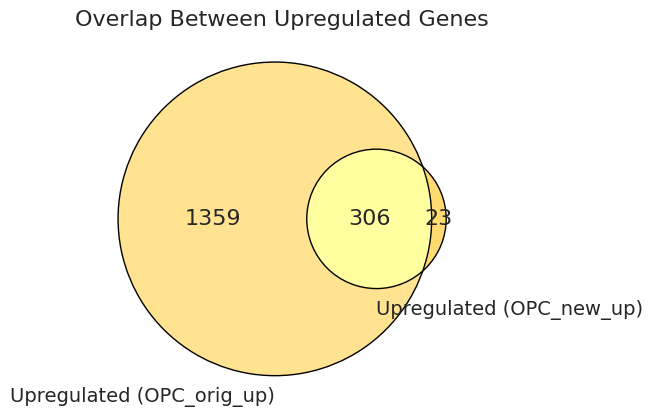

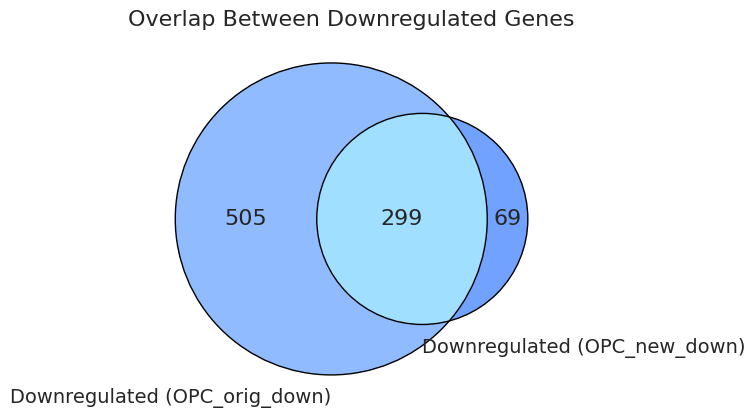

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles

# Assuming you have the original and new upregulated/downregulated dataframes
# Extract sets of gene symbols for comparison
set_OPC_orig_up = set(OPC_orig_up['gene'])
set_OPC_orig_down = set(OPC_orig_down['gene'])
set_OPC_new_up = set(OPC_new_up['gene'])
set_OPC_new_down = set(OPC_new_down['gene'])

# Calculate lengths and overlap for upregulated genes
length_orig_up_only = len(set_OPC_orig_up - set_OPC_new_up)
length_new_up_only = len(set_OPC_new_up - set_OPC_orig_up)
common_up = set_OPC_orig_up & set_OPC_new_up
length_common_up = len(common_up)

# Plot Venn diagram for upregulated genes
venn_up = venn2(subsets=(length_orig_up_only, length_new_up_only, length_common_up),
                set_labels=('Upregulated (OPC_orig_up)', 'Upregulated (OPC_new_up)'),
                set_colors=('#ffdd75', '#ffd34e'),
                alpha=0.8)

venn2_circles(subsets=(length_orig_up_only, length_new_up_only, length_common_up), linewidth=1)

# Customize font sizes
for subset in venn_up.subset_labels:
    if subset:
        subset.set_fontsize(16)
for text in venn_up.set_labels:
    text.set_fontsize(14)

# Add a title and show the plot
plt.title('Overlap Between Upregulated Genes', fontsize=16)
plt.show()

# Calculate lengths and overlap for downregulated genes
length_orig_down_only = len(set_OPC_orig_down - set_OPC_new_down)
length_new_down_only = len(set_OPC_new_down - set_OPC_orig_down)
common_down = set_OPC_orig_down & set_OPC_new_down
length_common_down = len(common_down)

# Plot Venn diagram for downregulated genes
venn_down = venn2(subsets=(length_orig_down_only, length_new_down_only, length_common_down),
                  set_labels=('Downregulated (OPC_orig_down)', 'Downregulated (OPC_new_down)'),
                  set_colors=('#75aaff', '#4e8bff'),
                  alpha=0.8)

venn2_circles(subsets=(length_orig_down_only, length_new_down_only, length_common_down), linewidth=1)

# Customize font sizes
for subset in venn_down.subset_labels:
    if subset:
        subset.set_fontsize(16)
for text in venn_down.set_labels:
    text.set_fontsize(14)

# Add a title and show the plot
plt.title('Overlap Between Downregulated Genes', fontsize=16)
plt.show()

In [89]:
print(length_common_up)
print(common_up)

306
{'PIEZO1', 'AC022784.1', 'TUBB2A', 'ACAT2', 'GNB2', 'PHACTR1', 'ARHGDIA', 'GALNT7', 'SORL1', 'FAAP20', 'AL356417.3', 'BTN3A2', 'LRRN1', 'BACE2', 'WWC2', 'PKNOX2', 'DOCK7', 'KCND3', 'ANO10', 'VWA5A', 'GRIK3', 'FAM129B', 'SLC6A6', 'ST8SIA5', 'SLC2A9', 'LGI4', 'FMNL3', 'KCTD9', 'DDX60', 'HAS1', 'TNFRSF19', 'KLF6', 'C2CD2', 'PLXND1', 'DCAF15', 'COQ10B', 'SCCPDH', 'BTN3A3', 'DHCR24', 'ADAM19', 'ITGB5', 'RALB', 'AC092903.2', 'RTN2', 'HLA-F', 'C3orf70', 'RGS16', 'ELOVL2', 'RFC2', 'BTBD6', 'HELB', 'JDP2', 'DCTD', 'R3HCC1', 'ERAP2', 'TRIM25', 'ABCA6', 'CAPNS1', 'KLF10', 'FLOT2', 'PTPRM', 'ANKDD1A', 'GAS2L3', 'DDX60L', 'TMEM150C', 'DDR1', 'OR4N2', 'CD59', 'BTG1', 'GBP2', 'TLE1', 'SCARA3', 'MIDN', 'GALNT15', 'ARHGAP39', 'PTPRU', 'FOXP4', 'NAV2', 'ARHGAP24', 'TMEM109', 'SPATA1', 'SETBP1', 'AC004812.2', 'PPP3CC', 'ELF4', 'TSPAN8', 'SALL1', 'NCMAP', 'WSCD1', 'ABLIM3', 'GGH', 'RGMB', 'SLC22A4', 'TNFAIP8', 'GINS2', 'EHD2', 'PARP14', 'NR4A1', 'ITPR3', 'GPRC5A', 'MAFF', 'CAMK2D', 'SIPA1L2', 'AKIRIN2

In [90]:
print(length_common_down)
print(common_down)

299
{'LINC00639', 'GRAMD2B', 'RAMP1', 'AC011043.1', 'PLPPR1', 'AC008050.1', 'ATP8A2', 'AC006270.1', 'AC009063.3', 'CLCA4-AS1', 'LRIG3', 'CFAP70', 'CDH23', 'PALM2-AKAP2', 'AC093423.3', 'AC004158.1', 'DPH6-DT', 'PALM2', 'AC069114.1', 'AC007221.1', 'IFNA2', 'C1orf162', 'ARHGAP1', 'LINC02177', 'RGS5', 'FXYD7', 'AL353732.1', 'LINC01099', 'NOS1', 'ITM2A', 'AL109910.1', 'LAMA2', 'LINC00891', 'ZFYVE16', 'ATG4C', 'ADAMTS8', 'SOD3', 'ROR1', 'CHD7', 'HS3ST5', 'SCUBE2', 'AC007376.2', 'PEX11G', 'AL136460.1', 'LINC01170', 'HILPDA', 'SNAP25-AS1', 'APCDD1', 'AC016383.2', 'AL592183.1', 'PTN', 'AC098650.1', 'MT-CO2', 'PURG', 'AL078590.3', 'HID1', 'AC090092.1', 'TMEM232', 'IFNG-AS1', 'TMEM132B', 'AC111152.2', 'INSYN2B', 'AL031121.2', 'GNG8', 'SVEP1', 'MT-ATP6', 'LINC02060', 'PABPC1L', 'CCDC160', 'AC026746.1', 'AC009163.6', 'CADM2', 'FHL1', 'AC093627.3', 'GRIA2', 'PTPDC1', 'PPM1H', 'AL121768.1', 'GRIA3', 'PGBD4', 'ZNF117', 'SEC14L5', 'AC009271.1', 'LCP1', 'UNG', 'AC115622.1', 'CTNND2', 'AP003100.2', 'MIR1